## Convolutional Neural Network - Data Augmentation

#### For classifying audio data in the UrbanSound8K dataset with an augmented dataset.

In this notebook we run our model created in the CNN notebook on an augmented dataset.
We use the same fucntions that were created in the last notebook.

## Load Libraries

In [3]:
import json
import random
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow
import tensorflow.keras as keras
from keras.regularizers import l2
from sklearn.model_selection import KFold

## Load Data

In this step we load the augmented data. The process is described in the pre processment notebook.

In [4]:
#Deve atualizar a sua localização em relação ao ficheiro
data = pd.read_json("/content/drive/MyDrive/files/features_mfcc40.json")

In [5]:
data

,file,transformed,salience,fold,classID,mfcc40
0,135776-2-0-49.wav,false,2,1,2,"[[0.1043594405, 0.0525185205, 0.0584450252, 0...."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
2,augmented0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
3,57320-0-0-24.wav,false,2,1,0,"[[0.2571681142, 0.19033260640000002, 0.1936520..."
4,134717-0-0-26.wav,false,1,1,0,"[[0.1350698918, 0.0285070594, 0.0413862392, 0...."
...,...,...,...,...,...,...
10141,88121-8-0-0.wav,false,2,10,8,"[[0.0431582965, 0.031919945000000005, 0.038528..."
10142,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268406900000004, 0.047489263100000..."
10143,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.080786258, 0.1064587533, 0.09..."
10144,99192-4-0-7.wav,false,1,10,4,"[[0.1716143936, 0.31627538800000005, 0.2538642..."


In [6]:
class_counts = data['classID'].value_counts()
class_counts

6    1081
8    1073
2    1000
0    1000
7    1000
4    1000
5    1000
3    1000
9    1000
1     992
Name: classID, dtype: int64

We have MFCCs with different shapes, so we check to see are index of those MFCC and remove them from the dataset.

In [7]:
def dif_shape(df, rep, shape):
    list = []
    for i in range(len(df)):
        m = df.loc[i][rep]
        n = np.array(m)
        if(n.shape != shape):
            list.append(i)
    return list


In [8]:
list = dif_shape(data, 'mfcc40', (40,321))
data1 = data.drop(list)
data1

,file,transformed,salience,fold,classID,mfcc40
0,135776-2-0-49.wav,false,2,1,2,"[[0.1043594405, 0.0525185205, 0.0584450252, 0...."
1,46654-6-0-0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
2,augmented0.wav,false,1,1,6,"[[0.0, 0.026401408, 0.026924215300000002, 0.30..."
3,57320-0-0-24.wav,false,2,1,0,"[[0.2571681142, 0.19033260640000002, 0.1936520..."
4,134717-0-0-26.wav,false,1,1,0,"[[0.1350698918, 0.0285070594, 0.0413862392, 0...."
...,...,...,...,...,...,...
10141,88121-8-0-0.wav,false,2,10,8,"[[0.0431582965, 0.031919945000000005, 0.038528..."
10142,189982-0-0-42.wav,false,1,10,0,"[[0.0, 0.055268406900000004, 0.047489263100000..."
10143,74364-8-1-7.wav,false,2,10,8,"[[0.033702936, 0.080786258, 0.1064587533, 0.09..."
10144,99192-4-0-7.wav,false,1,10,4,"[[0.1716143936, 0.31627538800000005, 0.2538642..."


In [9]:
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

## Split the Data

In [10]:
def to_array(list):
    new_list = []
    for m in list:
        m1 = np.array(m)
        new_list.append(m1)
    array = np.array(new_list)
    return array

def split_data_cross_validation(representation, df, test_fold):
    #dividir folds
    folds = [1,2,3,4,5,6,7,8,9,10]

    test_fold = test_fold
    folds.remove(test_fold)
    validation_fold = random.choice(folds)
    folds.remove(validation_fold)
    train_folds = folds

    #separar dataframe df de acordo com os folds resultantes
    test_data = df[df['fold'] == test_fold]
    train_data = df[df['fold'].isin(train_folds)]
    validation_data = df[df['fold'] == validation_fold]

    # Separar as features e os labels
    x_train = train_data[representation].values
    X_train = to_array(x_train)
    y_train = train_data['classID'].values

    x_validation = validation_data[representation].values
    X_validation = to_array(x_validation)
    y_validation = validation_data['classID'].values

    x_test = test_data[representation].values
    X_test = to_array(x_test)
    y_test = test_data['classID'].values

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

## Training and testing the model

Metrics Functions:

In [12]:
def confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis =1)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labels)
    cm_display.plot(xticks_rotation='vertical')
    plt.show()
    return y_pred, confusion_matrix

In [14]:
def acc_per_class(conf_matrix):
    total_samples_per_class = np.sum(conf_matrix, axis=1)
    correct_predictions_per_class = np.diag(conf_matrix)
    accuracies = correct_predictions_per_class / total_samples_per_class
    return accuracies

Our final model:

In [11]:
def build_model(input_shape):
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3),kernel_regularizer=l2(0.01), input_shape=input_shape))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.SpatialDropout2D(0.1))

    model.add(keras.layers.Conv2D(64, (3, 3), kernel_regularizer=l2(0.01)))
    model.add(keras.layers.LeakyReLU(alpha=0.1))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.SpatialDropout2D(0.2))

    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

Perform the 10-cross validation:

In [19]:
def save(dic,tl,tc,yp,re,cm,i):
    dic[f"loss{i}"] = tl
    dic[f"acc{i}"] = tc
    dic[f"pred{i}"] = yp
    dic[f"report{i}"] = re
    dic[f"confusion_matrix{i}"] = cm
    
def ten_fold_cross_validation(df,representation):
    input_shape = (40,321,1)
    dictionary = {}

    for i in range(1,11):
        X_train, y_train, X_valid, y_valid, X_test, y_test = split_data_cross_validation('mfcc40', df, i)
        #Build and compile the model
        model = build_model(input_shape)
        optimiser = keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=60, batch_size=100)

        #Evaluate and save model statistics
        test_loss, test_acc = model.evaluate(X_test, y_test)
        y_pred, cm = confusion_matrix(model, X_test, y_test)
        report = classification_report(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

        save(dictionary, test_loss, test_acc, y_pred, report, cm, i)

    return dictionary

Epoch 1/60
81/81 [==============================] - 4s 24ms/step - loss: 3.9134 - accuracy: 0.2230 - val_loss: 3.9625 - val_accuracy: 0.1708
Epoch 2/60
81/81 [==============================] - 2s 19ms/step - loss: 3.4902 - accuracy: 0.3350 - val_loss: 4.0353 - val_accuracy: 0.1021
Epoch 3/60
81/81 [==============================] - 2s 19ms/step - loss: 3.2913 - accuracy: 0.3777 - val_loss: 4.2210 - val_accuracy: 0.1083
Epoch 4/60
81/81 [==============================] - 2s 19ms/step - loss: 3.1124 - accuracy: 0.4261 - val_loss: 4.9241 - val_accuracy: 0.1094
Epoch 5/60
81/81 [==============================] - 2s 19ms/step - loss: 2.9514 - accuracy: 0.4567 - val_loss: 3.8675 - val_accuracy: 0.1437
Epoch 6/60
81/81 [==============================] - 2s 19ms/step - loss: 2.8150 - accuracy: 0.4874 - val_loss: 3.5922 - val_accuracy: 0.2042
Epoch 7/60
81/81 [==============================] - 2s 19ms/step - loss: 2.6784 - accuracy: 0.5175 - val_loss: 2.8750 - val_accuracy: 0.4313
Epoch 8/60
81

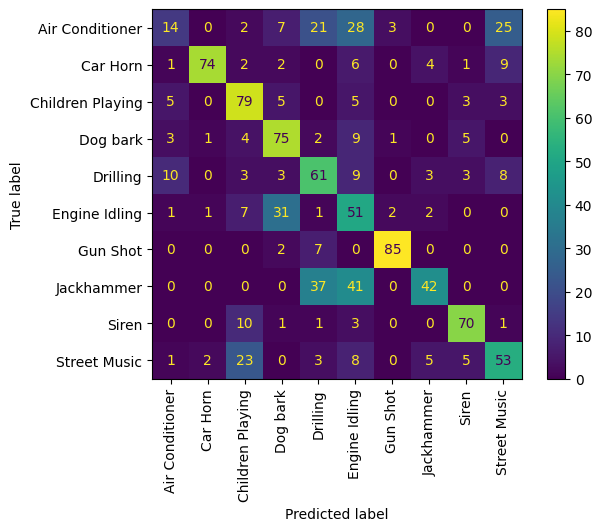

Epoch 1/60
79/79 [==============================] - 4s 25ms/step - loss: 3.8880 - accuracy: 0.2303 - val_loss: 3.9808 - val_accuracy: 0.1129
Epoch 2/60
79/79 [==============================] - 2s 19ms/step - loss: 3.4372 - accuracy: 0.3512 - val_loss: 3.9599 - val_accuracy: 0.1275
Epoch 3/60
79/79 [==============================] - 2s 19ms/step - loss: 3.1846 - accuracy: 0.4243 - val_loss: 4.0972 - val_accuracy: 0.1166
Epoch 4/60
79/79 [==============================] - 2s 19ms/step - loss: 2.9764 - accuracy: 0.4611 - val_loss: 4.4541 - val_accuracy: 0.1175
Epoch 5/60
79/79 [==============================] - 2s 20ms/step - loss: 2.8252 - accuracy: 0.4994 - val_loss: 4.2209 - val_accuracy: 0.1667
Epoch 6/60
79/79 [==============================] - 2s 19ms/step - loss: 2.6608 - accuracy: 0.5401 - val_loss: 3.7978 - val_accuracy: 0.1958
Epoch 7/60
79/79 [==============================] - 2s 20ms/step - loss: 2.5352 - accuracy: 0.5507 - val_loss: 3.1610 - val_accuracy: 0.3406
Epoch 8/60
79

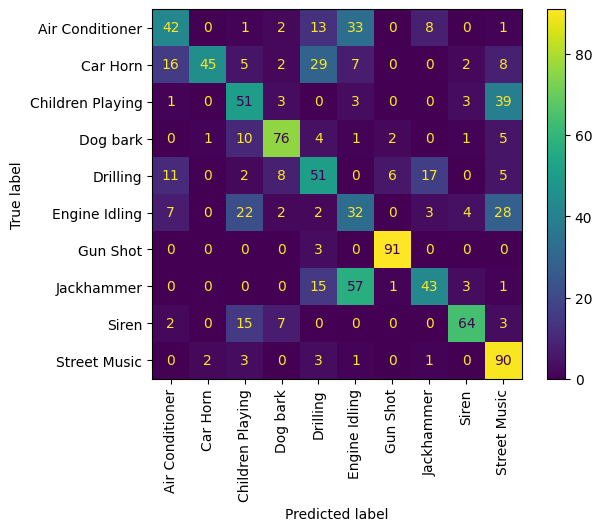

Epoch 1/60
80/80 [==============================] - 3s 23ms/step - loss: 3.9326 - accuracy: 0.2289 - val_loss: 3.9934 - val_accuracy: 0.1094
Epoch 2/60
80/80 [==============================] - 2s 19ms/step - loss: 3.5071 - accuracy: 0.3332 - val_loss: 4.2263 - val_accuracy: 0.1094
Epoch 3/60
80/80 [==============================] - 2s 19ms/step - loss: 3.2680 - accuracy: 0.4065 - val_loss: 4.7623 - val_accuracy: 0.1094
Epoch 4/60
80/80 [==============================] - 2s 19ms/step - loss: 3.0787 - accuracy: 0.4513 - val_loss: 4.2376 - val_accuracy: 0.1411
Epoch 5/60
80/80 [==============================] - 2s 19ms/step - loss: 2.9249 - accuracy: 0.4896 - val_loss: 4.1312 - val_accuracy: 0.1893
Epoch 6/60
80/80 [==============================] - 2s 19ms/step - loss: 2.7744 - accuracy: 0.5070 - val_loss: 3.5868 - val_accuracy: 0.2582
Epoch 7/60
80/80 [==============================] - 2s 19ms/step - loss: 2.6388 - accuracy: 0.5365 - val_loss: 2.8656 - val_accuracy: 0.4311
Epoch 8/60
80

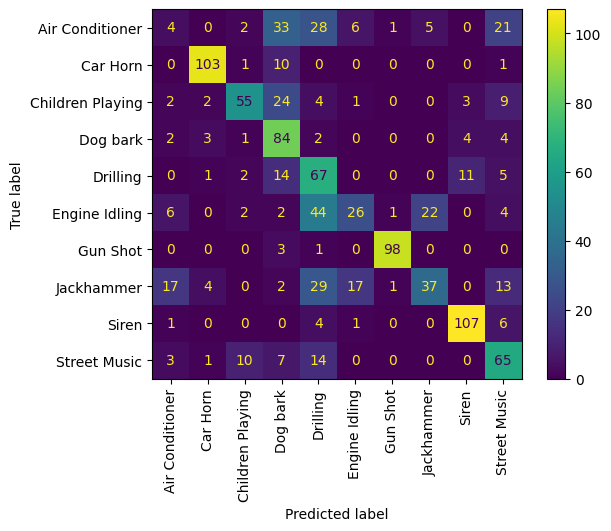

Epoch 1/60
80/80 [==============================] - 3s 24ms/step - loss: 3.9721 - accuracy: 0.1961 - val_loss: 4.0069 - val_accuracy: 0.1038
Epoch 2/60
80/80 [==============================] - 2s 19ms/step - loss: 3.5914 - accuracy: 0.2871 - val_loss: 4.0850 - val_accuracy: 0.1038
Epoch 3/60
80/80 [==============================] - 2s 19ms/step - loss: 3.3484 - accuracy: 0.3625 - val_loss: 4.0926 - val_accuracy: 0.1111
Epoch 4/60
80/80 [==============================] - 2s 19ms/step - loss: 3.1560 - accuracy: 0.4164 - val_loss: 3.8847 - val_accuracy: 0.1869
Epoch 5/60
80/80 [==============================] - 2s 19ms/step - loss: 2.9771 - accuracy: 0.4492 - val_loss: 3.7102 - val_accuracy: 0.1630
Epoch 6/60
80/80 [==============================] - 2s 19ms/step - loss: 2.8263 - accuracy: 0.4831 - val_loss: 3.2863 - val_accuracy: 0.3188
Epoch 7/60
80/80 [==============================] - 2s 19ms/step - loss: 2.6830 - accuracy: 0.5089 - val_loss: 2.7982 - val_accuracy: 0.4382
Epoch 8/60
80

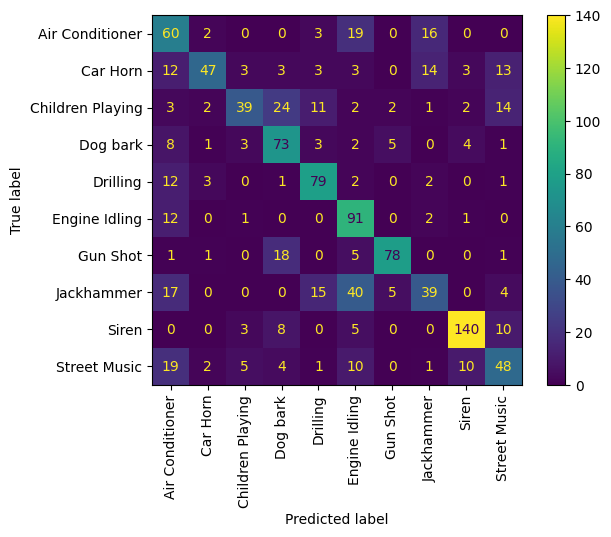

Epoch 1/60
79/79 [==============================] - 4s 25ms/step - loss: 3.9382 - accuracy: 0.2076 - val_loss: 3.9911 - val_accuracy: 0.0911
Epoch 2/60
79/79 [==============================] - 2s 19ms/step - loss: 3.5099 - accuracy: 0.3329 - val_loss: 4.0597 - val_accuracy: 0.0947
Epoch 3/60
79/79 [==============================] - 2s 19ms/step - loss: 3.2957 - accuracy: 0.3875 - val_loss: 4.3324 - val_accuracy: 0.0947
Epoch 4/60
79/79 [==============================] - 2s 19ms/step - loss: 3.0974 - accuracy: 0.4274 - val_loss: 4.5997 - val_accuracy: 0.0947
Epoch 5/60
79/79 [==============================] - 2s 19ms/step - loss: 2.9228 - accuracy: 0.4684 - val_loss: 4.6885 - val_accuracy: 0.1302
Epoch 6/60
79/79 [==============================] - 2s 19ms/step - loss: 2.7502 - accuracy: 0.5067 - val_loss: 4.0893 - val_accuracy: 0.1758
Epoch 7/60
79/79 [==============================] - 2s 19ms/step - loss: 2.6353 - accuracy: 0.5209 - val_loss: 3.5153 - val_accuracy: 0.2304
Epoch 8/60
79

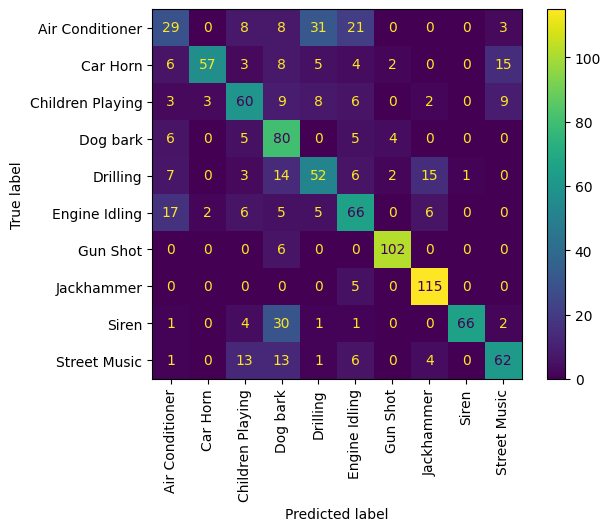

Epoch 1/60
81/81 [==============================] - 4s 25ms/step - loss: 3.9177 - accuracy: 0.2239 - val_loss: 3.9639 - val_accuracy: 0.1005
Epoch 2/60
81/81 [==============================] - 2s 19ms/step - loss: 3.5078 - accuracy: 0.3283 - val_loss: 4.2032 - val_accuracy: 0.1055
Epoch 3/60
81/81 [==============================] - 2s 19ms/step - loss: 3.2703 - accuracy: 0.3854 - val_loss: 4.3572 - val_accuracy: 0.0945
Epoch 4/60
81/81 [==============================] - 2s 19ms/step - loss: 3.1193 - accuracy: 0.4175 - val_loss: 4.1381 - val_accuracy: 0.0965
Epoch 5/60
81/81 [==============================] - 2s 19ms/step - loss: 2.9436 - accuracy: 0.4564 - val_loss: 3.3625 - val_accuracy: 0.2784
Epoch 6/60
81/81 [==============================] - 2s 19ms/step - loss: 2.8013 - accuracy: 0.4772 - val_loss: 2.9335 - val_accuracy: 0.4241
Epoch 7/60
81/81 [==============================] - 2s 19ms/step - loss: 2.6588 - accuracy: 0.5057 - val_loss: 2.6858 - val_accuracy: 0.4553
Epoch 8/60
81

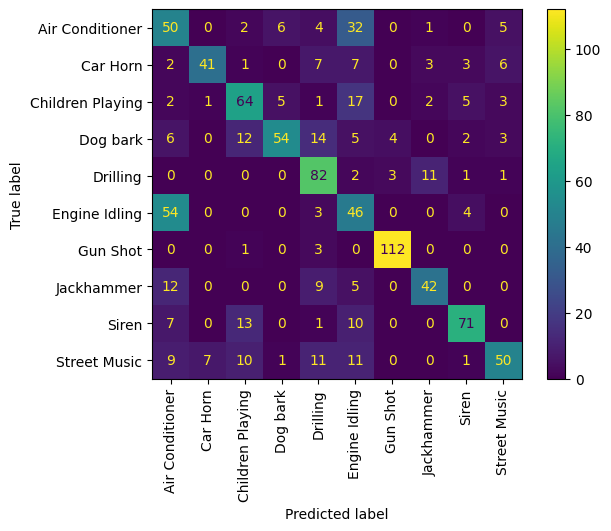

Epoch 1/60
80/80 [==============================] - 5s 24ms/step - loss: 3.9349 - accuracy: 0.2036 - val_loss: 3.9570 - val_accuracy: 0.0911
Epoch 2/60
80/80 [==============================] - 2s 19ms/step - loss: 3.5503 - accuracy: 0.3091 - val_loss: 3.9778 - val_accuracy: 0.1220
Epoch 3/60
80/80 [==============================] - 2s 19ms/step - loss: 3.3266 - accuracy: 0.3625 - val_loss: 3.9532 - val_accuracy: 0.1375
Epoch 4/60
80/80 [==============================] - 2s 19ms/step - loss: 3.1096 - accuracy: 0.4075 - val_loss: 3.7755 - val_accuracy: 0.1922
Epoch 5/60
80/80 [==============================] - 2s 19ms/step - loss: 2.9489 - accuracy: 0.4392 - val_loss: 3.7554 - val_accuracy: 0.1466
Epoch 6/60
80/80 [==============================] - 2s 19ms/step - loss: 2.8052 - accuracy: 0.4649 - val_loss: 3.3389 - val_accuracy: 0.2377
Epoch 7/60
80/80 [==============================] - 2s 19ms/step - loss: 2.6718 - accuracy: 0.4922 - val_loss: 3.1514 - val_accuracy: 0.2778
Epoch 8/60
80

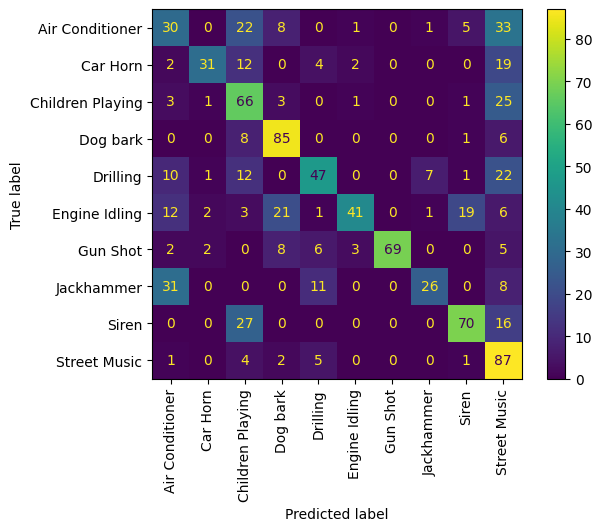

Epoch 1/60
81/81 [==============================] - 4s 25ms/step - loss: 3.9354 - accuracy: 0.2233 - val_loss: 3.9766 - val_accuracy: 0.1011
Epoch 2/60
81/81 [==============================] - 2s 19ms/step - loss: 3.5284 - accuracy: 0.3295 - val_loss: 3.9961 - val_accuracy: 0.1011
Epoch 3/60
81/81 [==============================] - 2s 19ms/step - loss: 3.2739 - accuracy: 0.4065 - val_loss: 4.0550 - val_accuracy: 0.2700
Epoch 4/60
81/81 [==============================] - 2s 19ms/step - loss: 3.0898 - accuracy: 0.4474 - val_loss: 3.8950 - val_accuracy: 0.1739
Epoch 5/60
81/81 [==============================] - 2s 19ms/step - loss: 2.8908 - accuracy: 0.4906 - val_loss: 3.8526 - val_accuracy: 0.2639
Epoch 6/60
81/81 [==============================] - 2s 19ms/step - loss: 2.7631 - accuracy: 0.5218 - val_loss: 3.3372 - val_accuracy: 0.3327
Epoch 7/60
81/81 [==============================] - 2s 19ms/step - loss: 2.6409 - accuracy: 0.5362 - val_loss: 2.9639 - val_accuracy: 0.4237
Epoch 8/60
81

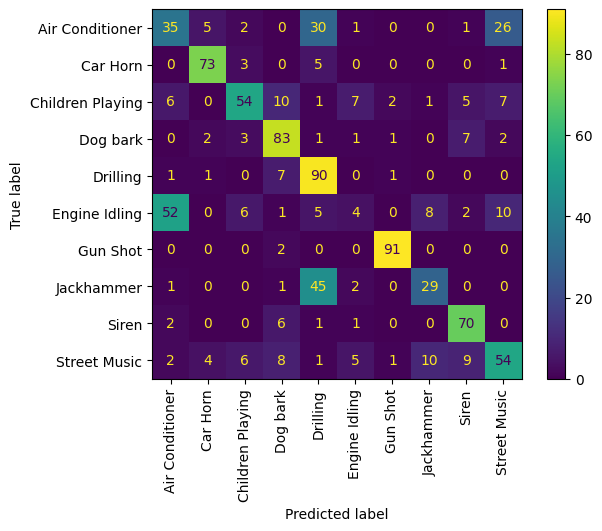

Epoch 1/60
82/82 [==============================] - 4s 24ms/step - loss: 4.0259 - accuracy: 0.1982 - val_loss: 3.9853 - val_accuracy: 0.0853
Epoch 2/60
82/82 [==============================] - 2s 20ms/step - loss: 3.6087 - accuracy: 0.2937 - val_loss: 3.9687 - val_accuracy: 0.1171
Epoch 3/60
82/82 [==============================] - 2s 19ms/step - loss: 3.3778 - accuracy: 0.3575 - val_loss: 3.9679 - val_accuracy: 0.1707
Epoch 4/60
82/82 [==============================] - 2s 19ms/step - loss: 3.1959 - accuracy: 0.3958 - val_loss: 3.8298 - val_accuracy: 0.1772
Epoch 5/60
82/82 [==============================] - 2s 19ms/step - loss: 3.0488 - accuracy: 0.4342 - val_loss: 3.5402 - val_accuracy: 0.2385
Epoch 6/60
82/82 [==============================] - 2s 19ms/step - loss: 2.8856 - accuracy: 0.4761 - val_loss: 3.0749 - val_accuracy: 0.3993
Epoch 7/60
82/82 [==============================] - 2s 19ms/step - loss: 2.7665 - accuracy: 0.4912 - val_loss: 2.7707 - val_accuracy: 0.4584
Epoch 8/60
82

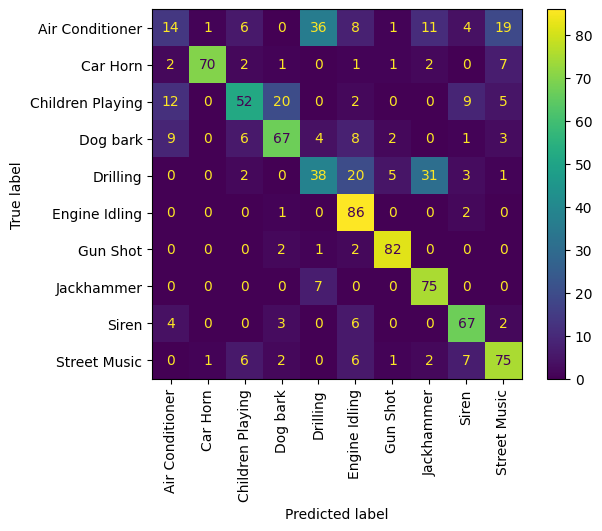

Epoch 1/60
80/80 [==============================] - 4s 26ms/step - loss: 3.9564 - accuracy: 0.2135 - val_loss: 3.9725 - val_accuracy: 0.1005
Epoch 2/60
80/80 [==============================] - 2s 19ms/step - loss: 3.5571 - accuracy: 0.3169 - val_loss: 4.0168 - val_accuracy: 0.1005
Epoch 3/60
80/80 [==============================] - 2s 19ms/step - loss: 3.3143 - accuracy: 0.3763 - val_loss: 4.2993 - val_accuracy: 0.1045
Epoch 4/60
80/80 [==============================] - 2s 20ms/step - loss: 3.1364 - accuracy: 0.4159 - val_loss: 4.1772 - val_accuracy: 0.1276
Epoch 5/60
80/80 [==============================] - 2s 19ms/step - loss: 2.9846 - accuracy: 0.4527 - val_loss: 3.8530 - val_accuracy: 0.1799
Epoch 6/60
80/80 [==============================] - 2s 19ms/step - loss: 2.8083 - accuracy: 0.4868 - val_loss: 3.3204 - val_accuracy: 0.2211
Epoch 7/60
80/80 [==============================] - 2s 19ms/step - loss: 2.6797 - accuracy: 0.5158 - val_loss: 2.7544 - val_accuracy: 0.4623
Epoch 8/60
80

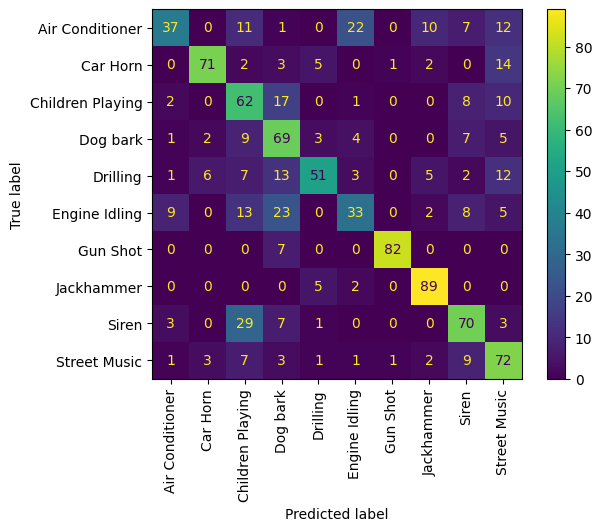

In [20]:
dictionary = ten_fold_cross_validation(data1,'mfcc40')

## Results

#### Test Loss

In [22]:
for i in range(1,11):
    name = f"loss{i}"
    print(f"test_loss{i}: ",dictionary[name])

test_loss1:  1.8789618015289307
test_loss2:  1.800251841545105
test_loss3:  1.745568871498108
test_loss4:  1.5336757898330688
test_loss5:  1.5258218050003052
test_loss6:  1.4987659454345703
test_loss7:  1.6560420989990234
test_loss8:  1.597267985343933
test_loss9:  1.6649315357208252
test_loss10:  1.456551432609558


**Mean Loss:** 1.6357839107513428

#### Test Accuracy

In [23]:
for i in range(1,11):
    name = f"acc{i}"
    print(f"test_acc{i}: ",dictionary[name])

test_acc1:  0.6070351600646973
test_acc2:  0.5740922689437866
test_acc3:  0.6077139973640442
test_acc4:  0.6320582628250122
test_acc5:  0.6625000238418579
test_acc6:  0.6355140209197998
test_acc7:  0.574999988079071
test_acc8:  0.637855589389801
test_acc9:  0.676025927066803
test_acc10:  0.6430737972259521


**Mean Accuracy:** 0.6250869035720825

#### Reports

In [24]:
for i in range(1,11):
    print(f"Report{i}:")
    name = f"report{i}"
    print(dictionary[name])

Report1:
                  precision    recall  f1-score   support

 Air Conditioner       0.40      0.14      0.21       100
        Car Horn       0.95      0.75      0.84        99
Children Playing       0.61      0.79      0.69       100
        Dog bark       0.60      0.75      0.66       100
        Drilling       0.46      0.61      0.52       100
   Engine Idling       0.32      0.53      0.40        96
        Gun Shot       0.93      0.90      0.92        94
      Jackhammer       0.75      0.35      0.48       120
           Siren       0.80      0.81      0.81        86
    Street Music       0.54      0.53      0.53       100

        accuracy                           0.61       995
       macro avg       0.64      0.62      0.61       995
    weighted avg       0.63      0.61      0.60       995

Report2:
                  precision    recall  f1-score   support

 Air Conditioner       0.53      0.42      0.47       100
        Car Horn       0.94      0.39      0.56   

#### Accuracies Table

In [25]:
for i in range(1,11):
    print(f"Accuracy_table{i}")
    name = f"confusion_matrix{i}"
    cm = dictionary[name]
    accuracies = acc_per_class(cm)
    # Display per-class accuracy in a DataFrame
    result_df = pd.DataFrame({'CLASS': labels,'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)
    print(result_df)

Accuracy_table1
              CLASS  ACCURACY
6          Gun Shot  0.904255
8             Siren  0.813953
2  Children Playing  0.790000
3          Dog bark  0.750000
1          Car Horn  0.747475
4          Drilling  0.610000
5     Engine Idling  0.531250
9      Street Music  0.530000
7        Jackhammer  0.350000
0   Air Conditioner  0.140000
Accuracy_table2
              CLASS  ACCURACY
6          Gun Shot  0.968085
9      Street Music  0.900000
3          Dog bark  0.760000
8             Siren  0.703297
2  Children Playing  0.510000
4          Drilling  0.510000
0   Air Conditioner  0.420000
1          Car Horn  0.394737
7        Jackhammer  0.358333
5     Engine Idling  0.320000
Accuracy_table3
              CLASS  ACCURACY
6          Gun Shot  0.960784
8             Siren  0.899160
1          Car Horn  0.895652
3          Dog bark  0.840000
4          Drilling  0.670000
9      Street Music  0.650000
2  Children Playing  0.550000
7        Jackhammer  0.308333
5     Engine Idling  0

#### Mean Accuracies

Gun Shot: 0.9061772999999999

Dog Bark: 0.748

Siren: 0.7515442999999999

Street Music: 0.6559999999999999

Car Horn: 0.6530468999999999

Driling: 0.618

Children Playing: 0.5860645000000001

Jackhammer: 0.5473262999999999

Engine Idling: 0.4744815

Air Conditioner: 0.31500000000000006

## Comparar o mesmo CNN model para o dataset normal e dataset aumentado

### Sem data augmentation:

- Mean Accuracy - 0.5845692753791809
---
### Com data augmentation:

- Mean Accuracy - 0.6250869035720825